<a href="https://colab.research.google.com/github/GerardoDario/Algoritmos_No_Supervisados/blob/main/VC10_Otros_usos_de_aprendizaje_no_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# V10 - Otros usos de aprendizaje no-supervisado


El notebook de esta clase va a ser un poco diferente de los anteriores. En este caso vamos a ver dos ejemplos independientes de aprendizaje no-supervisado que no ha dado tiempo a ver en clase. El primero va a ser el uso de grafos para segmentación, y el segundo, el uso de modelos generativos adversarios para generación de contenido.

## Segmentación mediante grafos

Este algoritmo construye primero un grafo de adyacencia de regiones y luego realiza el corte mínimo normalizado. En fuentes podéis conocer más sobre cómo funciona el agoritmo.

Vamos a ver un ejemplo:

In [ ]:
!pip install scikit-image==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit-image-0.16.2.tar.gz (28.9 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for scikit-image
  Running setup.py clean for scikit-image
Failed to build scikit-image
ERROR: Could not build wheels for scikit-image, which is required to install pyproject.toml-based projects


### Corte normalizado

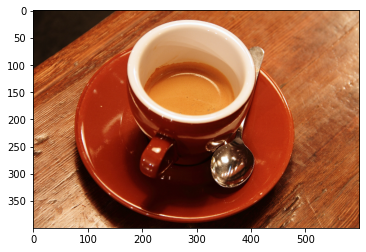

In [ ]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


img = data.coffee()
plt.imshow(img)

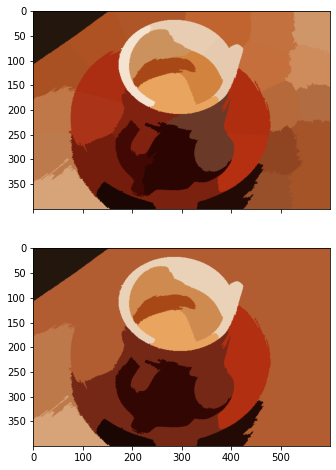

In [ ]:
labels1 = segmentation.slic(img, compactness=30, n_segments=40)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g) #otro ejemplo
out2 = color.label2rgb(labels2, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

### GrabCut:

En este ejemplo vamos a ver cómo podemos usar el corte mínimo de un grafo para segmentar background de foreground en una imagen.

Pongamos como ejemplo esta imagen:

<img src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/grabcut_output1.jpg">

Como podéis ver, disponemos de una bounding box y de semillas para background y para foreground.

Lo que hace el algoritmo de GrabCut es construir un grafo asignando todos los pixels o bien a una fuente a un sumidero, y después encuentra el mínimo corte en dicho grafo:

<img src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/grabcut.jpg">

Tenemos la suerte de que este algoritmo se encuentra implementado en OpenCV: `cv2.grabCut()`. Veamos sus argumentos.

`img` - Input image

`mask` - It is a mask image where we specify which areas are background, foreground or probable background/foreground etc. It is done by the following flags, cv2.GC_BGD, cv2.GC_FGD, cv2.GC_PR_BGD, cv2.GC_PR_FGD, or simply pass 0,1,2,3 to image.

`rect` - It is the coordinates of a rectangle which includes the foreground object in the format (x,y,w,h)

`bdgModel, fgdModel` - These are arrays used by the algorithm internally. You just create two np.float64 type zero arrays of size (1,65).

`iterCount` - Number of iterations the algorithm should run.

`mode` - It should be cv2.GC_INIT_WITH_RECT or cv2.GC_INIT_WITH_MASK or combined which decides whether we are drawing rectangle or final touchup strokes.

First let’s see with rectangular mode. We load the image, create a similar mask image. We create fgdModel and bgdModel. We give the rectangle parameters. It’s all straight-forward. Let the algorithm run for 5 iterations. Mode should be cv2.GC_INIT_WITH_RECT since we are using rectangle. Then run the grabcut. It modifies the mask image. In the new mask image, pixels will be marked with four flags denoting background/foreground as specified above. So we modify the mask such that all 0-pixels and 2-pixels are put to 0 (ie background) and all 1-pixels and 3-pixels are put to 1(ie foreground pixels). Now our final mask is ready. Just multiply it with input image to get the segmented image.

In [ ]:
!wget https://raw.githubusercontent.com/abidrahmank/OpenCV2-Python-Tutorials/master/data/messi5.jpg

--2022-10-13 18:24:26--  https://raw.githubusercontent.com/abidrahmank/OpenCV2-Python-Tutorials/master/data/messi5.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72937 (71K) [image/jpeg]
Saving to: ‘messi5.jpg.1’

messi5.jpg.1        100%[===================>]  71.23K  --.-KB/s    in 0.004s  

2022-10-13 18:24:26 (18.0 MB/s) - ‘messi5.jpg.1’ saved [72937/72937]



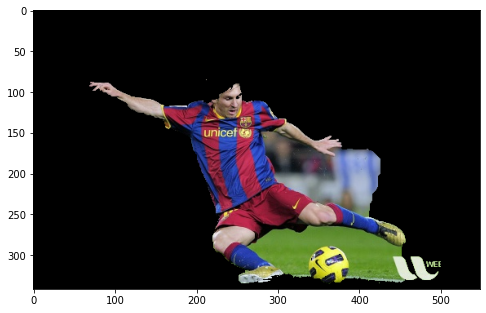

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

img_orig = cv2.imread('messi5.jpg')
mask = np.zeros(img_orig.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (50,50,450,290)
cv2.grabCut(img_orig, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img_orig*mask2[:,:,np.newaxis]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Fijaos que el pelo y el cesped entre las piernas no se ha segmentado bien. ¿Cómo podemos arreglarlo?

In [ ]:
!wget -O newmask.png https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ6doDpZUR3q0TeUQyjBUc_dB-N6xBfCnNOp4SbxDumtKDB_1TG&s

/bin/bash: s: command not found
--2022-10-13 18:24:34--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ6doDpZUR3q0TeUQyjBUc_dB-N6xBfCnNOp4SbxDumtKDB_1TG
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 142.250.188.206, 2607:f8b0:4004:835::200e
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|142.250.188.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2798 (2.7K) [image/png]
Saving to: ‘newmask.png’

newmask.png         100%[===================>]   2.73K  --.-KB/s    in 0s      

2022-10-13 18:24:34 (52.6 MB/s) - ‘newmask.png’ saved [2798/2798]



(<matplotlib.image.AxesImage at 0x7fb1f2cecc10>,
 <matplotlib.image.AxesImage at 0x7fb1f2cf9090>)

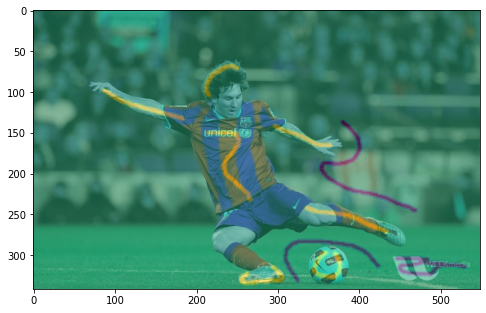

In [ ]:
# newmask is the mask image I manually labelled
newmask = cv2.imread('newmask.png',0)
newmask = cv2.resize(newmask, img.shape[:2][::-1])
plt.imshow(img_orig), plt.imshow(newmask, alpha=0.5)

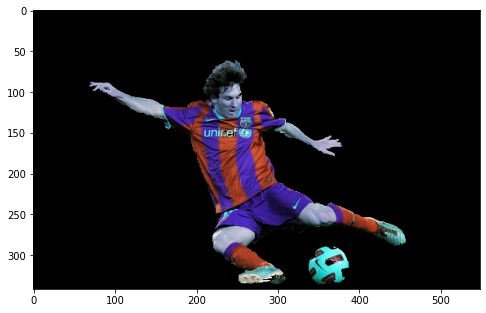

In [ ]:
mask[newmask == 0] = 0
mask[newmask == 255] = 1

mask, bgdModel, fgdModel = cv2.grabCut(img_orig,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img_orig*mask[:,:,np.newaxis]
plt.imshow(img)



Y afinando más la máscara, podríamos llegar a obtener perfectamente a Messi sin nada de fondo.

### Fuentes:

- https://scikit-image.org/docs/0.16.x/auto_examples/segmentation/plot_ncut.html?highlight=normalized%20cut
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_grabcut/py_grabcut.html

### Recursos interesantes:

- https://medium.com/stellargraph/knowing-your-neighbours-machine-learning-on-graphs-9b7c3d0d5896

In [ ]:
# Enlaces para el algoritmo PageRank
# https://medium.com/analytics-vidhya/how-google-search-works-page-rank-algorithm-using-python-9643d9c9a981
# https://medium.com/@arpanspeaks/custom-pagerank-implementation-in-python-and-verification-in-ms-excel-9ab6c690aaf5
## Enlace para algoritmo de asociación ##
# https://intellipaat.com/blog/data-science-apriori-algorithm/
# https://pbpython.com/market-basket-analysis.html
# https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/
# https://medium.com/swlh/a-tutorial-about-market-basket-analysis-in-python-predictive-hacks-497dc6e06b27

### Fuentes

- https://github.com/Madhu009/Deep-math-machine-learning.ai/blob/master/Gan's/vanillaGAN.ipynb

### Recursos

- https://github.com/Madhu009/Deep-math-machine-learning.ai/tree/master/Gan's
- https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/
- https://machinelearningmastery.com/resources-for-getting-started-with-generative-adversarial-networks/
- https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
- http://ganocracy.csail.mit.edu/tutorial/tutorial.html
- https://poloclub.github.io/ganlab/
- https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29
- https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/
- http://www.gatsby.ucl.ac.uk/~balaji/Understanding-GANs.pdf
- https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

### Trabajos interesantes

- https://medium.com/syncedreview/gan-2-0-nvidias-hyperrealistic-face-generator-e3439d33ebaf
- https://github.com/NVIDIA/vid2vid